In [127]:
%matplotlib inline
%run notebook_setup.py

<Figure size 640x480 with 0 Axes>

In [128]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
from corner import corner

starry.config.quiet = True

In [129]:
import theano
print("Theano version:", theano.__version__)


import pymc3
print("PyMC3 version:", pymc3.__version__)

import exoplanet
print("Exoplanet version:", exoplanet.__version__)

Theano version: 1.1.2
PyMC3 version: 3.11.5
Exoplanet version: 0.5.3


In [172]:
# True values
truth1 = dict(contrast1=-0.001, radius1=15, lat1=45, lon1=30)
truth2 = dict(contrast2=-0.001, radius2=35, lat2=10, lon2=-90)

In [173]:
# Things we'll assume are known
inc = 60.0
P = 1.0

In [178]:
map = starry.Map(ydeg=10,udeg=2,rv=True)
map.inc = inc
map.spot(
    contrast=truth1["contrast1"],
    radius=truth1["radius1"],
    lat=truth1["lat1"],
    lon=truth1["lon1"],
)
map.spot(
    contrast=truth2["contrast2"],
    radius=truth2["radius2"],
    lat=truth2["lat2"],
    lon=truth2["lon2"],
)

# Limb Darkening
map[1] = 0.5
map[2] = 0.25

vrot = 113 # km/s
map.obl = 0
map.veq = vrot*1000 # in m/s

map.show(rv=False, theta=np.linspace(0, 360, 50))
map.show(rv=True, theta=np.linspace(0, 360, 50))

In [179]:
t = np.linspace(0, 2.0, 500)
flux0 = map.flux(theta=360.0 / P * t)
np.random.seed(0)
flux_err = 2e-5
flux = flux0 + flux_err * np.random.randn(len(t))

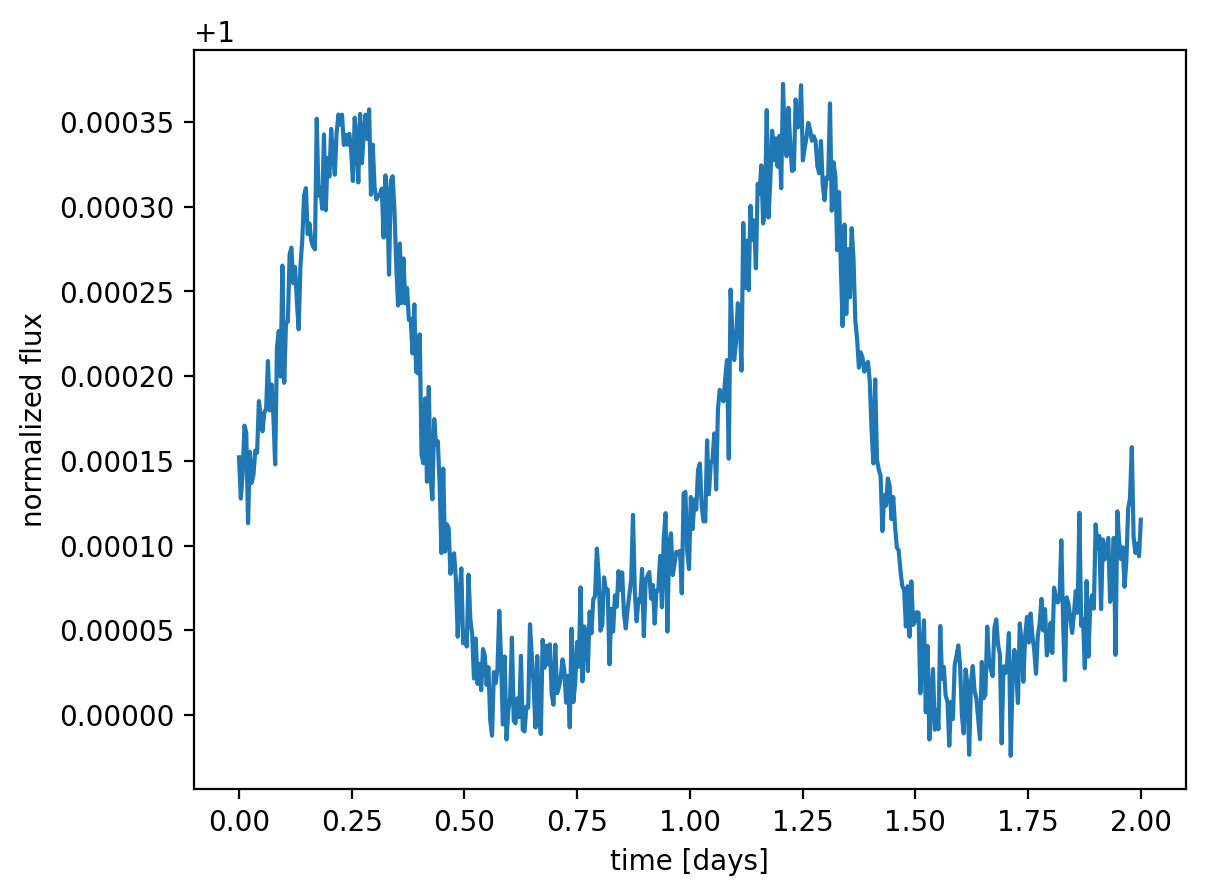

In [180]:
flux_numpy = flux.eval()

plt.plot(t, flux_numpy)
plt.xlabel("time [days]")
plt.ylabel("normalized flux");

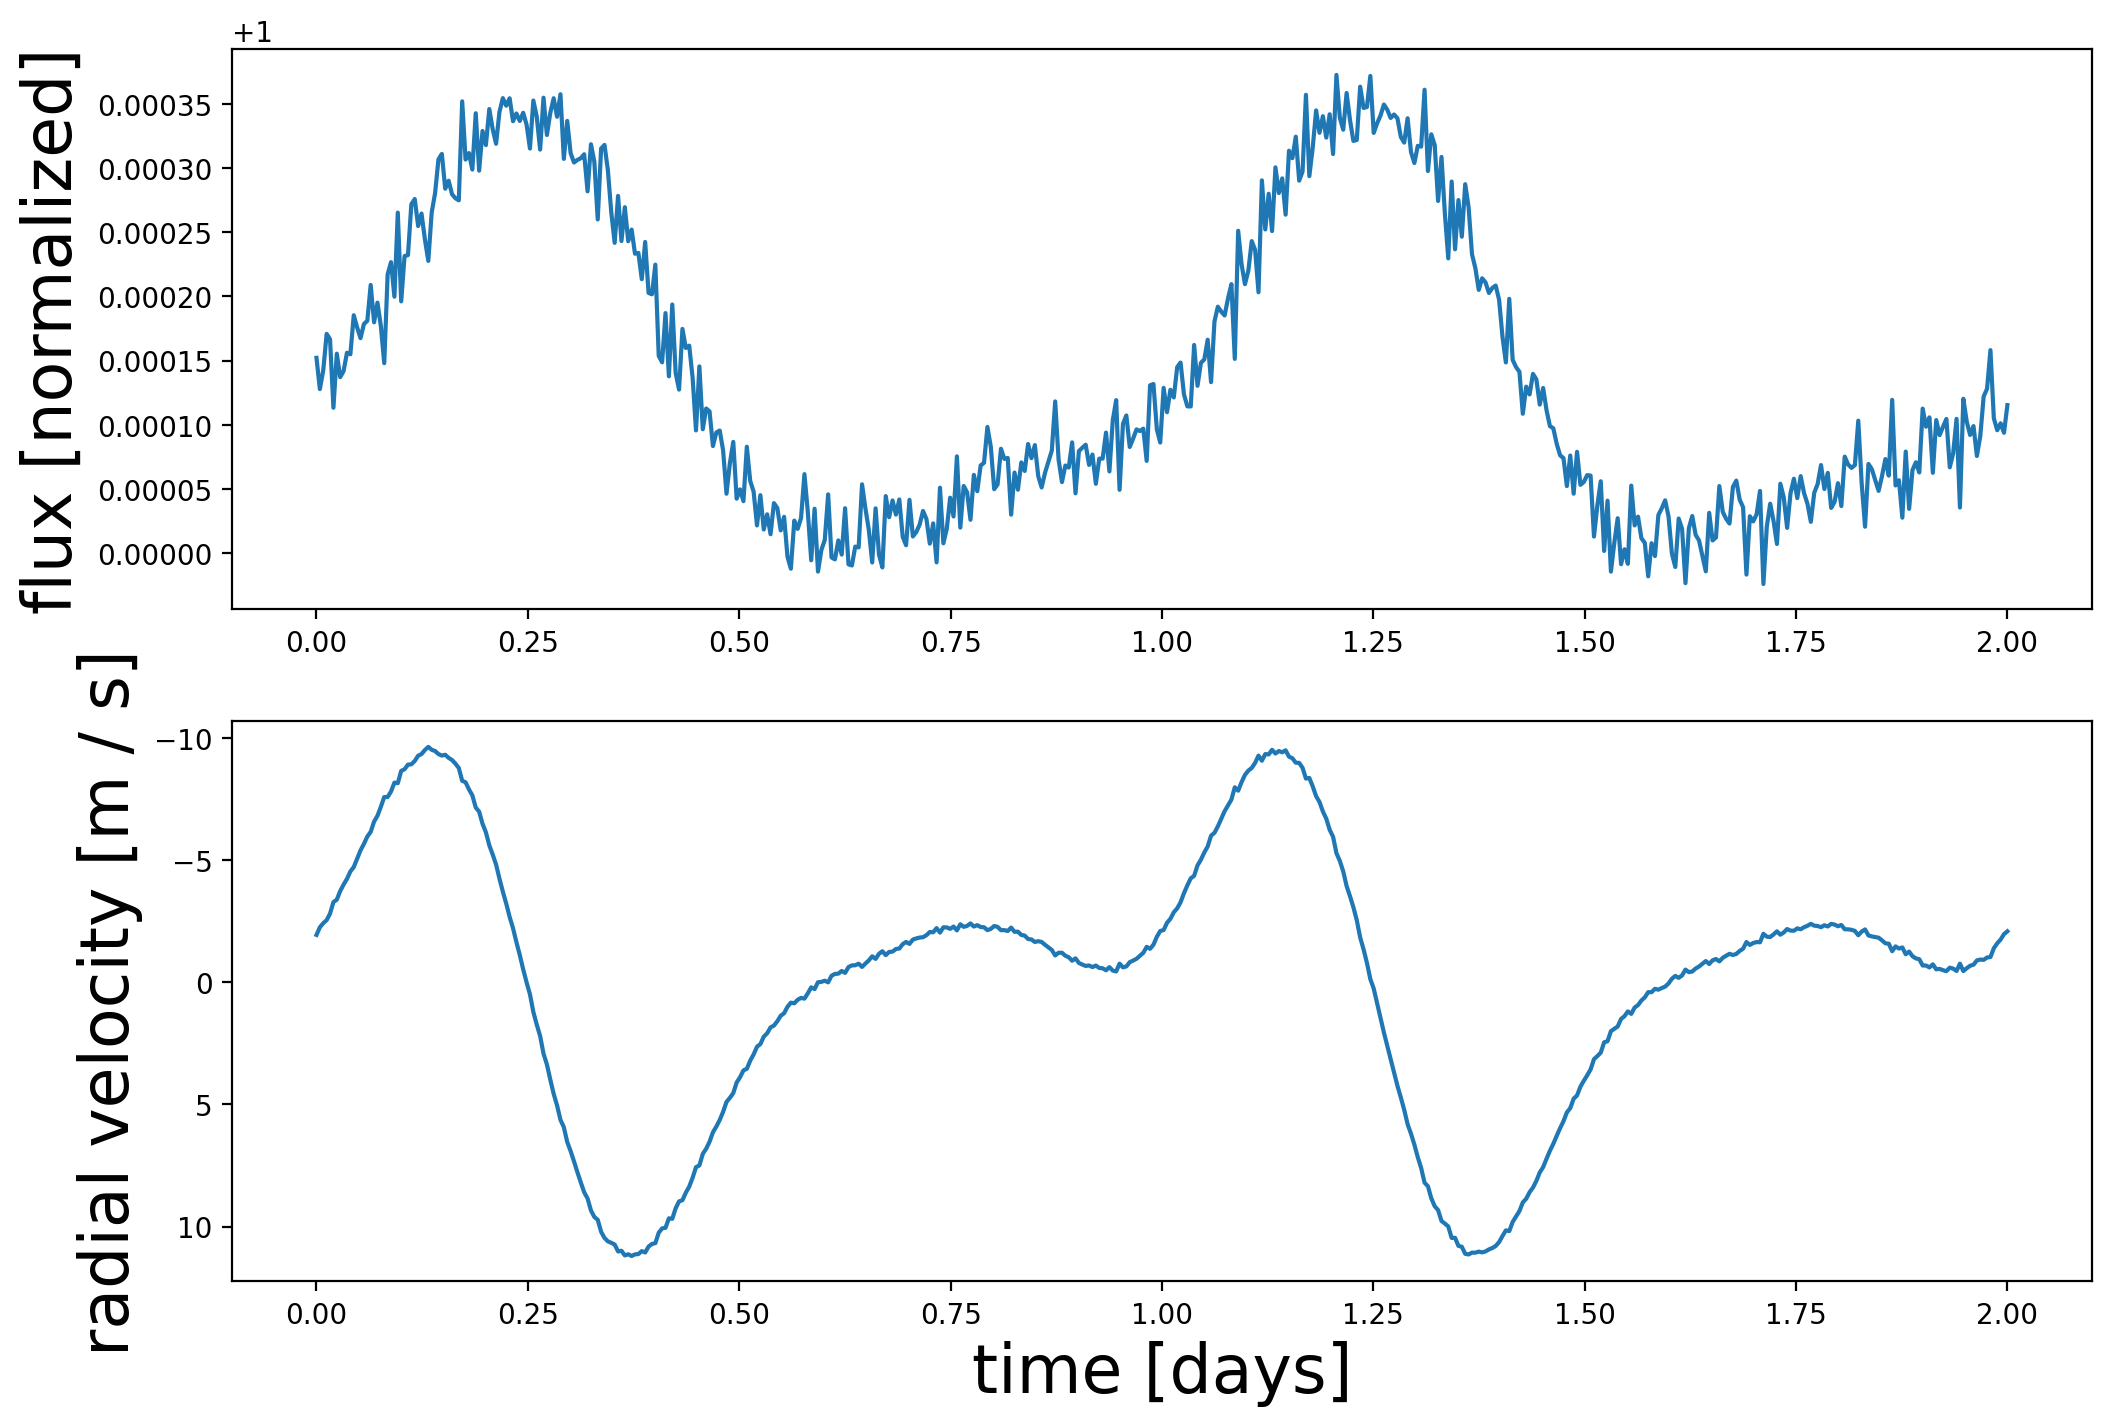

In [181]:
# Compute the  RV signal
rv0 = map.rv(theta=360.0 / P * t)
np.random.seed(0)
rv_err = 8e-2
rv = rv0 + rv_err * np.random.randn(len(t))

flux_numpy = flux.eval()
rv_numpy = rv.eval()

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux_numpy)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [normalized]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

In [182]:
with pm.Model() as model:

    # Priors
    contrast1 = pm.Uniform("contrast1", lower=0.0, upper=1.0, testval=0.5)
    radius1 = pm.Uniform("radius1", lower=5.0, upper=40.0, testval=15.0)
    lat1 = pm.Uniform("lat1", lower=-90.0, upper=90.0, testval=0.1)
    lon1 = pm.Uniform("lon1", lower=-180.0, upper=180.0, testval=0.1)

    contrast2 = pm.Uniform("contrast2", lower=-1.0, upper=0.0, testval=-0.5)
    radius2 = pm.Uniform("radius2", lower=5.0, upper=40.0, testval=15.0)
    lat2 = pm.Uniform("lat2", lower=-90.0, upper=90.0, testval=0.1)
    lon2 = pm.Uniform("lon2", lower=-180.0, upper=180.0, testval=0.1)

    # Instantiate the map and add the spot
    map = starry.Map(ydeg=15)
    map.inc = inc
    map.spot(contrast=contrast1, radius=radius1, lat=lat1, lon=lon1)
    map.spot(contrast=contrast2, radius=radius2, lat=lat2, lon=lon2)

    # Compute the flux model
    flux_model = map.flux(theta=360.0 / P * t)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux_numpy)

In [183]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon2, lat2, radius2, contrast2, lon1, lat1, radius1, contrast1]


message: Desired error not necessarily achieved due to precision loss.
logp: -15825.75213563961 -> 4682.003259238896


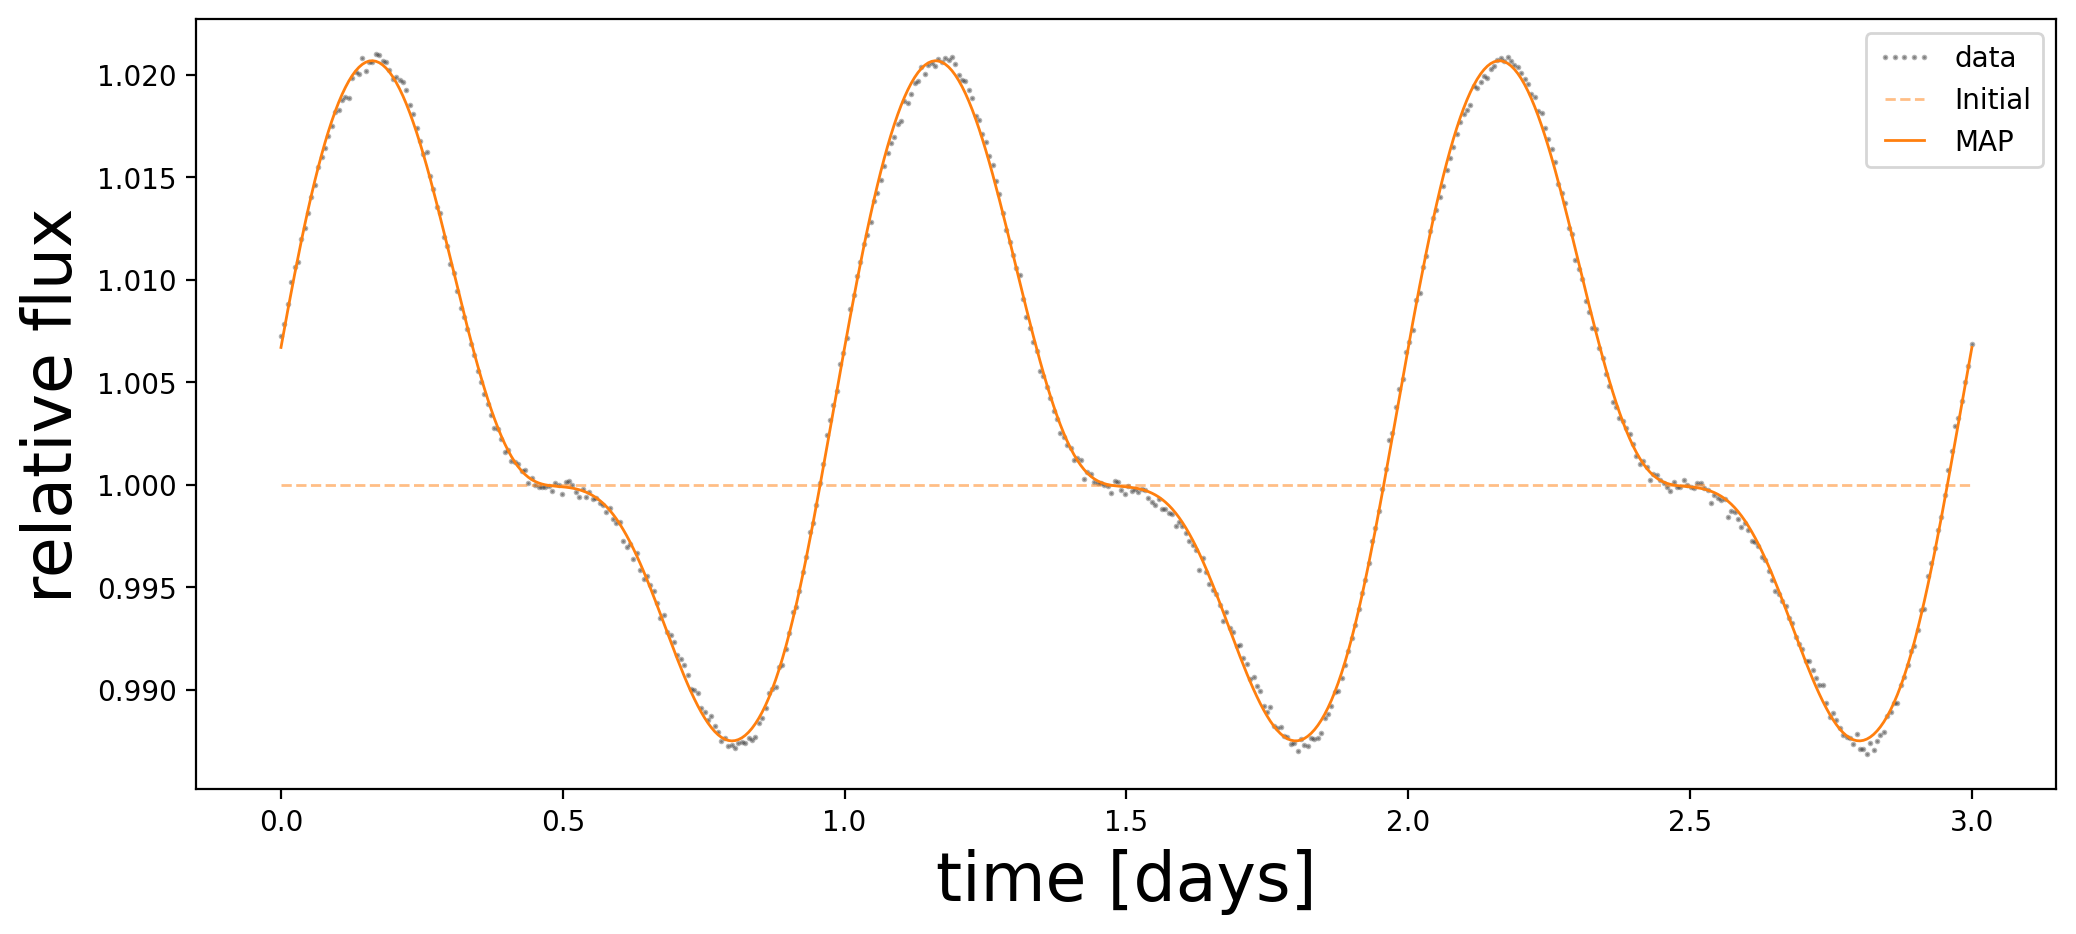

In [120]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux_numpy, "k.", alpha=0.3, ms=2, label="data")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [121]:
print("{0:12s} {1:10s} {2:10s}".format("", "truth", "map_soln"))
for key in truth1.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth1[key], map_soln[key]))
for key in truth2.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth2[key], map_soln[key]))    

             truth      map_soln  
contrast1     0.25000    0.98734
radius1      15.00000   25.71877
lat1         45.00000  -65.59444
lon1         30.00000   71.90316
contrast2    -0.10000   -0.17818
radius2      35.00000   28.49189
lat2          0.00000  -28.72941
lon2        -40.00000  -58.14285


In [122]:
with model:
    trace = pmx.sample(tune=250, draws=500, start=map_soln, chains=4, target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lon2, lat2, radius2, contrast2, lon1, lat1, radius1, contrast1]
INFO:pymc3:NUTS: [lon2, lat2, radius2, contrast2, lon1, lat1, radius1, contrast1]


/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 250 tune and 500 draw iterations (1_000 + 2_000 draws total) took 49 seconds.
INFO:pymc3:Sampling 4 chains for 250 tune an

In [1]:
var_names = ["contrast1", "radius1", "lat1", "lon1"]
display(pm.summary(trace, var_names=var_names))

NameError: name 'pm' is not defined

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=var_names)
corner(samples, truths=[truth[name] for name in var_names]);